## Proyecto Final Redes Neuronales

- Martínez Cano Ricardo Iván 
- Victoria Morales Ricardo Maximiliano

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import glob
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader    


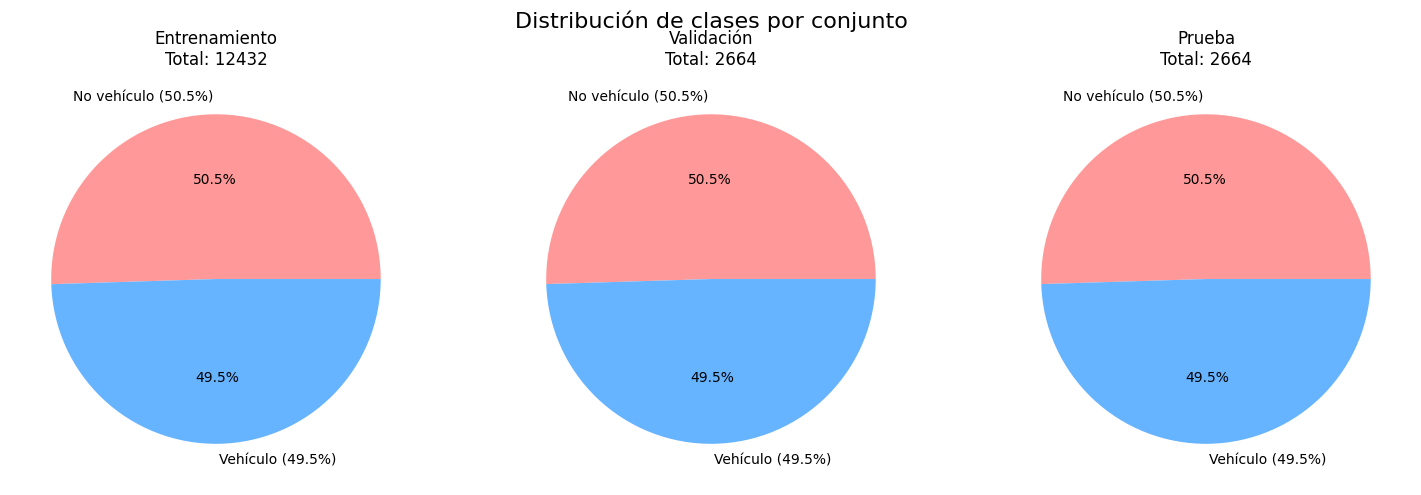

In [2]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import train_test_split
import os

# 1. Transformaciones
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 2. Cargar dataset
dataset = datasets.ImageFolder(root='data', transform=transform)
targets = np.array([label for _, label in dataset.samples])  # 0 o 1

# 3. División estratificada
train_idx, temp_idx = train_test_split(
    np.arange(len(targets)), test_size=0.3, stratify=targets, random_state=42
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=targets[temp_idx], random_state=42
)

# 4. Guardar índices
os.makedirs("splits", exist_ok=True)
np.save("splits/train_idx.npy", train_idx)
np.save("splits/val_idx.npy", val_idx)
np.save("splits/test_idx.npy", test_idx)

# 5. Subsets y DataLoaders
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 6. Función de balance
def obtener_balance(loader):
    counts = torch.zeros(2)
    for _, labels in loader:
        for label in labels:
            counts[label.item()] += 1
    total = counts.sum().item()
    porcentajes = 100.0 * counts / total
    return counts.tolist(), porcentajes.tolist(), int(total)

# 7. Preparar visualización
clases = ['No vehículo', 'Vehículo']
conjuntos = ['Entrenamiento', 'Validación', 'Prueba']
loaders = [train_loader, val_loader, test_loader]
os.makedirs("plots", exist_ok=True)

# 8. Gráficas individuales con conteo total
for loader, nombre in zip(loaders, conjuntos):
    cuentas, porcentajes, total = obtener_balance(loader)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.pie(cuentas, labels=[f"{clases[j]} ({porcentajes[j]:.1f}%)" for j in range(2)],
           autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    ax.set_title(f"Distribución de clases - {nombre}")
    plt.suptitle(f"Total de imágenes: {total}", fontsize=10)
    plt.savefig(f"plots/{nombre.lower()}_distribution.png")
    plt.close()

# 9. Figura combinada con conteos
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, loader in enumerate(loaders):
    cuentas, porcentajes, total = obtener_balance(loader)
    axes[i].pie(cuentas, labels=[f"{clases[j]} ({porcentajes[j]:.1f}%)" for j in range(2)],
                autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    axes[i].set_title(f"{conjuntos[i]}\nTotal: {total}")

plt.suptitle("Distribución de clases por conjunto", fontsize=16)
plt.tight_layout()
plt.savefig("plots/combined_distribution.png")
plt.show()

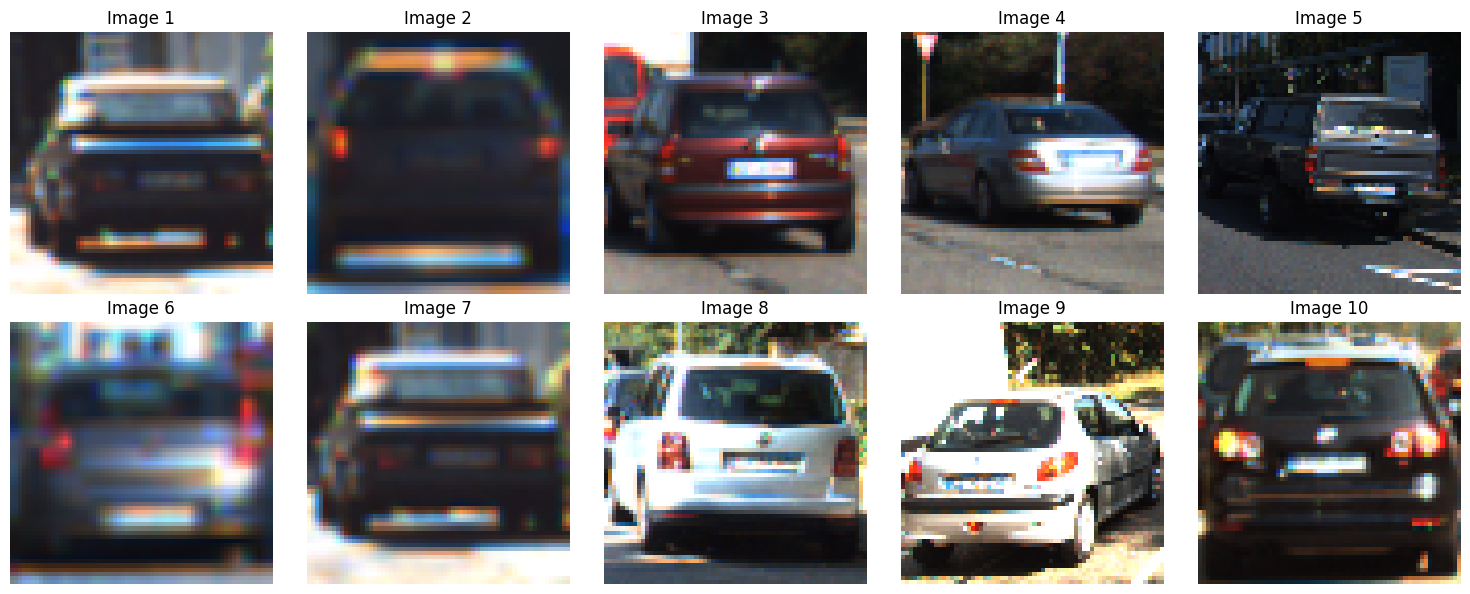

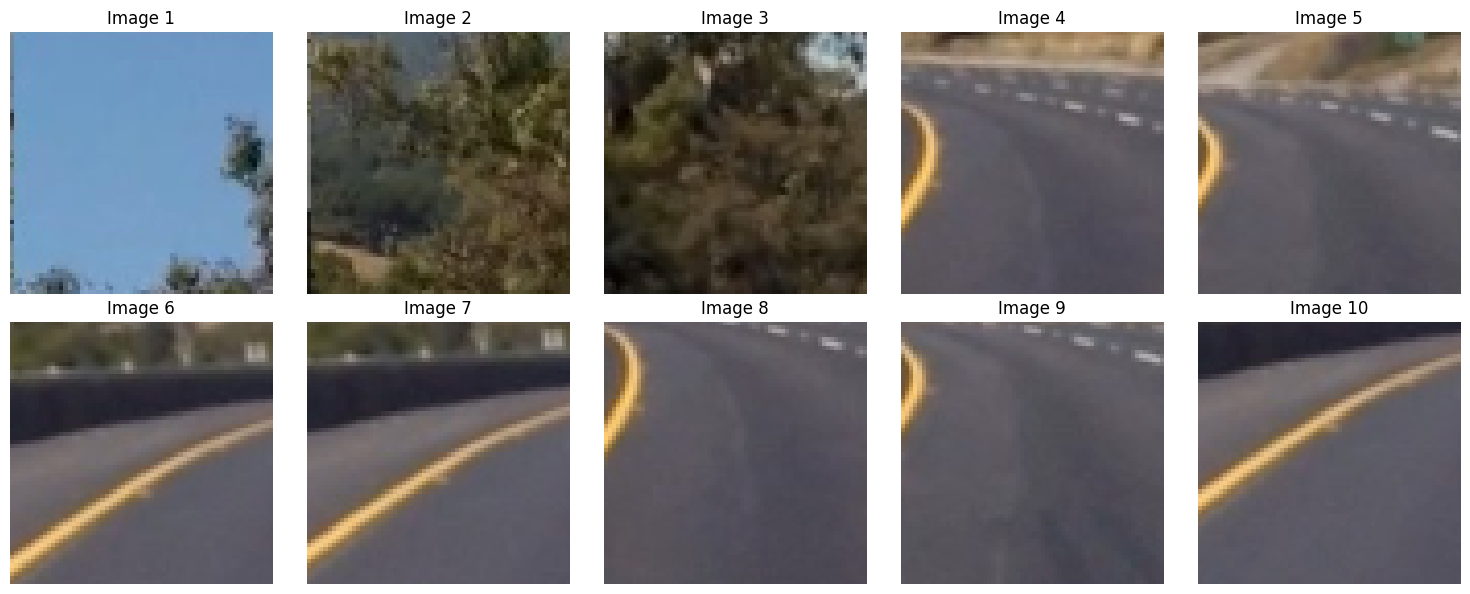

Total vehicle images: 8792
Total non-vehicle images: 8968


In [16]:
# Mostrar algunas imágenes de ejemplo
# Cargar imágenes de vehículos y no vehículos
vehicle_images = []
non_vehicle_images = []

vehicle_dir = 'data/vehicles'
non_vehicle_dir = 'data/non-vehicles'

for img_path in glob.glob(os.path.join(vehicle_dir, '*.png')):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        vehicle_images.append(img)

for img_path in glob.glob(os.path.join(non_vehicle_dir, '*.png')):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        non_vehicle_images.append(img)

# Función para mostrar imágenes
def display_images(images, ncols=5):
    """
    Muestra un conjunto de imágenes en una cuadrícula.
    """
    n_images = len(images)
    n_rows = (n_images + ncols - 1) // ncols  # Calcular número de filas
    fig, axes = plt.subplots(n_rows, ncols, figsize=(15, 3 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    for ax in axes:
        ax.axis('off')  # Ocultar ejes
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].set_title(f'Image {i+1}')
    
    plt.tight_layout()
    plt.show()

# Mostrar algunas imágenes de vehículos y no vehículos
display_images(vehicle_images[:10], ncols=5)
display_images(non_vehicle_images[:10], ncols=5)

# Verificar la cantidad de imágenes cargadas
print(f"Total vehicle images: {len(vehicle_images)}")
print(f"Total non-vehicle images: {len(non_vehicle_images)}")

In [3]:
class CNN(nn.Module): 
    def __init__(self): 
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc_input_size = 32 * 16 * 16  

        self.fc1 = nn.Linear(self.fc_input_size, 256)
        self.fc2 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))    

        x = x.view(-1, self.fc_input_size)
        x = self.dropout(x)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        return x
    


Starting epoch 1/10
Using device: cpu
Epoch [1/10] Loss: 0.4317 Accuracy: 91.41%
Starting epoch 2/10
Using device: cpu
Epoch [2/10] Loss: 0.1361 Accuracy: 97.11%
Starting epoch 3/10
Using device: cpu
Epoch [3/10] Loss: 0.0467 Accuracy: 98.50%
Starting epoch 4/10
Using device: cpu
Epoch [4/10] Loss: 0.0286 Accuracy: 99.06%
Starting epoch 5/10
Using device: cpu
Epoch [5/10] Loss: 0.0277 Accuracy: 99.12%
Starting epoch 6/10
Using device: cpu
Epoch [6/10] Loss: 0.0183 Accuracy: 99.39%
Starting epoch 7/10
Using device: cpu
Epoch [7/10] Loss: 0.0195 Accuracy: 99.34%
Starting epoch 8/10
Using device: cpu
Epoch [8/10] Loss: 0.0213 Accuracy: 99.29%
Starting epoch 9/10
Using device: cpu
Epoch [9/10] Loss: 0.0110 Accuracy: 99.68%
Starting epoch 10/10
Using device: cpu
Epoch [10/10] Loss: 0.0211 Accuracy: 99.32%


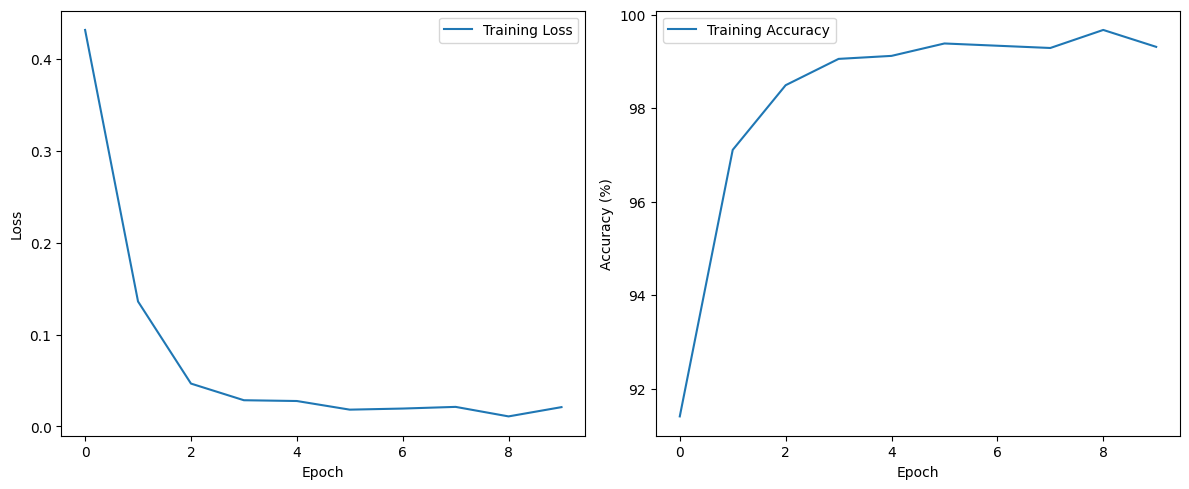

In [4]:
def train_model(model, dataloader, epochs=10, learning_rate=0.001, cuda=False):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}/{epochs}')
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{epochs}] '
              f'Loss: {epoch_loss:.4f} '
              f'Accuracy: {epoch_acc:.2f}%')

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, train_losses, train_accuracies
# Inicializar y entrenar el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN()
cnn_model, training_losses, training_accuracies = train_model(
    cnn_model,
    train_loader,
    epochs=10,
    learning_rate=0.001, 
    cuda=torch.cuda.is_available()
)



In [5]:
# Validación del modelo
def validate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')
    return accuracy

# Validar el modelo
validation_accuracy = validate_model(cnn_model, val_loader)


Validation Accuracy: 99.17%


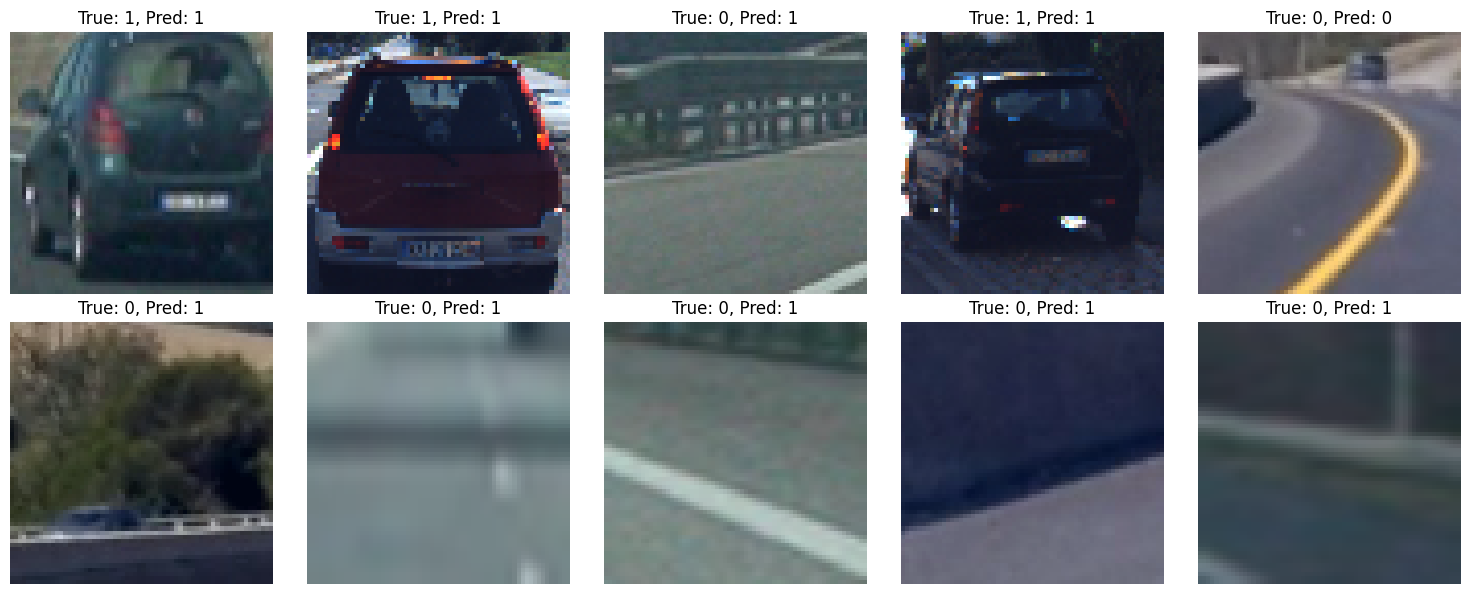

In [9]:
# Probar el modelo con un ejemplo de imagen
def test_model(model, image, transform=None):
    model.eval()
    if transform:
        image = transform(image).unsqueeze(0)  # Añadir dimensión de batch
    image = image.to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    return predicted.item()

#  Probar con diez imagenes de prueba
def test_model_with_examples(model, dataloader, transform=None):
    model.eval()
    examples = []
    labels = []
    
    with torch.no_grad():
        for inputs, lbls in dataloader:
            for i in range(len(inputs)):
                img = inputs[i]
                label = lbls[i].item()
                pred = test_model(model, img, transform)
                examples.append((img.cpu(), label, pred))
                if len(examples) >= 10:  # Limitar a 10 ejemplos
                    break
            if len(examples) >= 10:
                break
    
    return examples
# Probar el modelo con ejemplos
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
examples = test_model_with_examples(cnn_model, test_loader, transform)
# Visualizar ejemplos de prueba
def show_test_examples(examples):
    n = len(examples)
    ncols = 5
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows))
    axes = axes.flatten() if nrows > 1 else [axes]
    
    for ax in axes:
        ax.axis('off')  # Ocultar ejes
    
    for i, (img, label, pred) in enumerate(examples):
        img = img.permute(1, 2, 0).numpy()  # Convertir a formato HWC
        img = (img * 0.229 + 0.485) * 255.0  # Desnormalizar
        img = np.clip(img, 0, 255).astype(np.uint8)  # Asegurar valores válidos
        axes[i].imshow(img)
        axes[i].set_title(f'True: {label}, Pred: {pred}')
    
    plt.tight_layout()
    plt.show()
show_test_examples(examples)
# Guardar el modelo entrenado
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f'Model saved to {path}')

